In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns
import random
import torchvision

import torch
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [31]:
images_path = '../../data_train/' # Ruta de las imagenes
classes = os.listdir(images_path) # Carpetas con cada label.
print(f'Clases : {classes}')

Clases : ['paper', 'rock', 'scissors']


In [32]:
images,label = [],[] # Genero 2 listas con la ruta relativa de la imagen incluida esta, y otra con los labeles,
for ind,clase in enumerate(classes):
    direccion = os.listdir(f'{images_path}{clase}')
    images += [f'{images_path}{clase}/{img}' for img in direccion]
    label += [ind]*len(direccion)
print(images)
print(label)

['../../data/paper/04l5I8TqdzF9WDMJ.png', '../../data/paper/0a3UtNzl5Ll3sq8K.png', '../../data/paper/0cb6cVL8pkfi4wF6.png', '../../data/paper/0eqArS2GgsBeqgSn.png', '../../data/paper/0Og76sl5CJhbxWWx.png', '../../data/paper/0RA9rcrv8iVvuDDU.png', '../../data/paper/0t08v9bAaA0mXGCQ.png', '../../data/paper/0Uomd0HvOB33m47I.png', '../../data/paper/0vugygEjxQJPr9yz.png', '../../data/paper/0zKU6wEhT2cDe9j0.png', '../../data/paper/14K62H4KG1hg5qiJ.png', '../../data/paper/1Dfw5FRlS4h60JPX.png', '../../data/paper/1fKclJk4eBWOQSR1.png', '../../data/paper/1Frbe8cdOdkciOBg.png', '../../data/paper/1jHtb93pI8f6pfKo.png', '../../data/paper/1oKnUgV2CdCaQUUX.png', '../../data/paper/1Tt9U9SzrOm98Xtw.png', '../../data/paper/1uoW7QcH2qAgCTxv.png', '../../data/paper/1yeoLbmp4alVOtFv.png', '../../data/paper/1yKjzquSvl9ShK7K.png', '../../data/paper/27XFtQjjXQ8AP8Tl.png', '../../data/paper/2DQbLQfHlfrcATqi.png', '../../data/paper/2F8Ng7620ANA7tEK.png', '../../data/paper/2IOsxsG8AaxntdJM.png', '../../data/pap

### Labels: 0  = Papel,  1 = Rock , 2 = Scissors

In [33]:
clases = {
    0: 'Papel',
    1:'Rock',
    2:'Scissors'
}

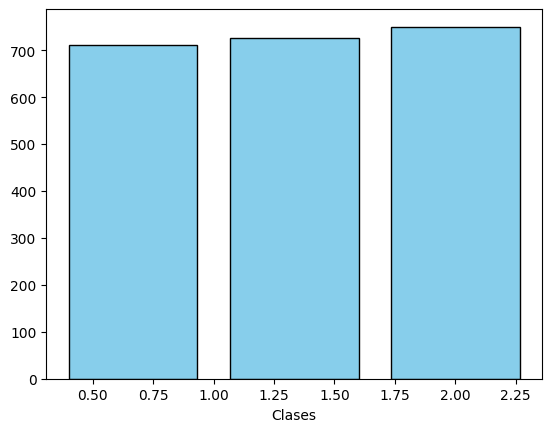

In [34]:
plt.hist(label,bins=3,align='right', rwidth=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Clases')
plt.show()

## Se puede observar una distribucion semejange entre las clases

## Voy a mostrar algunas imagenes

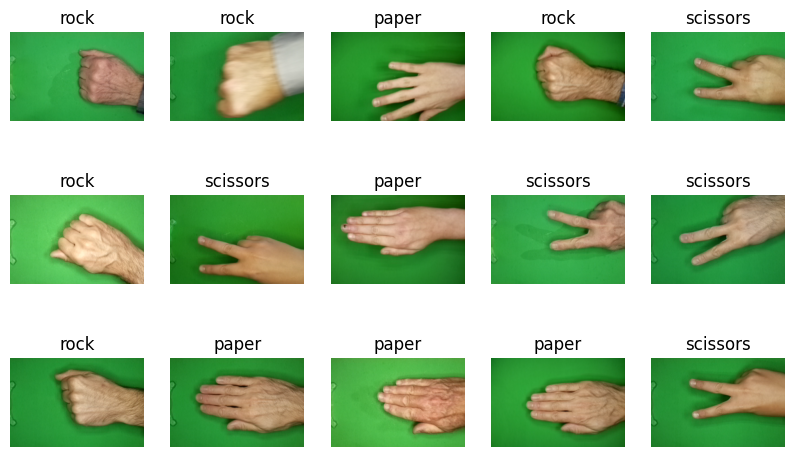

In [35]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(images)-1) # Genero un indice random para la lista de iamgenes
    img = io.imread(images[ix]) # Leo con imread a la imagen segun indice
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[label[ix]]) # Veo las clases con el indice
plt.show()

### Procedo a separar los datos en conjunto de entrenamiento y testeo


In [36]:
train_images, test_images, train_labels, test_labels = train_test_split(images, label, test_size=0.2, random_state=42)

A menudo Pytorch funciona mejor en tarjeta grafica, por esto genero una variable device para poder usarla en el caso de tenerse la posibilidad

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Ahora generare el conjunto de datos apropiado que pytorch necesita para el modelo,
para estoy primero voy a generar la clase Dataset que herada de Dataset de Pytorch, la cual tenedra como atributos el conjunto X y sus labels, ademas de un metodo(__getitem__) para tener los datos de forma apropiada

In [38]:
class Dataset(torch.utils.data.Dataset): # Genero la clase Dataset para las imagenes
  def __init__(self, X, y, trans, device):
    self.X = X # Conjunto de imagenes
    self.y = y # Clases
    self.trans = trans # Trasnformacion que pueda aplicarle
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix]) #Leo la imagen
    img = Image.fromarray(img)
    # aplicar transformaciones
    if self.trans: # Si incorpore una trasnformacion la aplico
      img = self.trans(img)
    return img, torch.tensor(self.y[ix]) #Retorno cfomo tensor, con la imagen normalizada y permutadando dfebido a los canales

Ahora voy a instanciar la clase Dataset, con mis datos, no sin antes definir un transformador para asegurarme que las imagenes tengan todas los tamaños adecuados

In [39]:
transform = transforms.Compose([

    transforms.Resize((224, 224)),
    transforms.ToTensor(),

]) # Realizo una trasnformacion para escalar las imagenes a 224x224

In [40]:
# Diccionario dataset, que contiene un objeto dataset para train y test
dataset = {
    'train': Dataset(train_images, train_labels, transform, device),
    'test': Dataset(test_images, test_labels, transform, device),

}

Para realizar un entrenamiento mas optimo para a definir dataloaders para tener batch de 64 imagnees

In [41]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

print(f'Conjunto de entrenamiento:{len(dataset["train"])},Conjunto de testeo:{len(dataset["test"])}')

Conjunto de entrenamiento:1750,Conjunto de testeo:438


Ahora que esta todo las dimensiones para poder aceptarse por pytorc deberian ser (64,3,224,224) para cada batch

In [42]:
for imgs, labels in iter(dataloader['train']):
  print(imgs.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([22, 3, 224, 224])


## Todo esta en orden, es momento de pasar a definir la red neuronal

In [43]:
# Funcion que se encarga del entrenamiento
def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    accuaracy_train,acuaracy_test = [],[]
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        accuaracy_train.append(np.mean(train_acc))
        acuaracy_test.append(np.mean(val_acc))
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
    return [accuaracy_train,acuaracy_test]

## Red neuronal creada por capas

### Definición de la red neuronal a partir de la arquitectura de la red resnet, modificando la capa de salida para que tenga 3 clases.

In [44]:
#Importo el modelo resnet, el cual es un modelo preentrenado con 1000 salidas
resnet = torchvision.models.resnet18()

In [45]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=3, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añado una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 3)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True


## 1 Caso: parametro pretrained = False es decir, no voy a usar los pesos que ya tiene el modelo, solo su estructura.

In [46]:
model = Model(pretrained=False)
epochs = 8
metrics = fit(model, dataloader, epochs=8)

c:\Proyects\image_classification\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Proyects\image_classification\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
val_loss 1.45651 val_acc 0.30552: 100%|██████████| 2/2 [00:29<00:00, 14.89s/it]


Epoch 1/8 loss 0.83987 val_loss 1.45651 acc 0.64966 val_acc 0.30552


val_loss 0.48014 val_acc 0.88921: 100%|██████████| 2/2 [00:26<00:00, 13.37s/it]


Epoch 2/8 loss 0.40600 val_loss 0.48014 acc 0.90965 val_acc 0.88921


val_loss 0.83211 val_acc 0.67604: 100%|██████████| 2/2 [00:37<00:00, 18.99s/it]


Epoch 3/8 loss 0.20883 val_loss 0.83211 acc 0.96931 val_acc 0.67604


val_loss 4.08566 val_acc 0.34916: 100%|██████████| 2/2 [00:23<00:00, 11.97s/it]


Epoch 4/8 loss 0.12584 val_loss 4.08566 acc 0.97940 val_acc 0.34916


val_loss 0.56557 val_acc 0.69527: 100%|██████████| 2/2 [00:24<00:00, 12.14s/it]


Epoch 5/8 loss 0.07991 val_loss 0.56557 acc 0.98443 val_acc 0.69527


val_loss 15.80506 val_acc 0.33665: 100%|██████████| 2/2 [00:24<00:00, 12.12s/it]


Epoch 6/8 loss 0.06353 val_loss 15.80506 acc 0.98889 val_acc 0.33665


val_loss 0.05596 val_acc 0.99255: 100%|██████████| 2/2 [00:36<00:00, 18.47s/it]


Epoch 7/8 loss 0.05831 val_loss 0.05596 acc 0.98661 val_acc 0.99255


val_loss 1.61327 val_acc 0.49371: 100%|██████████| 2/2 [00:31<00:00, 15.69s/it]

Epoch 8/8 loss 0.03513 val_loss 1.61327 acc 0.99219 val_acc 0.49371


## Se puede observar que la funcion de perdida obtuvo un valor bastante bajo primer epoch que fue 0.8

In [47]:
def plot_accuracy(epochs, metrics):
    plt.scatter(list(range(1,epochs+1)),metrics[0],label='Accuaricy Train')
    plt.scatter(list(range(1,epochs+1)),metrics[1],label='Accuaricy Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuaricy')
    plt.legend()
    plt.title("Rendimiento por cada iteración")
    plt.show()

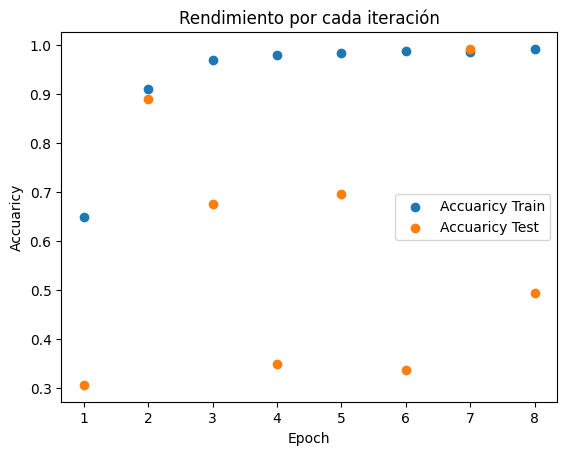

In [48]:
plot_accuracy(epochs, metrics)

## Se puede observar que en el epoch numero 7 se alcanza uno de los valores mas altos de accuaricy tanto para train como test, luego s ve que no aumenta tanto y ademas el accuaricy de test baja mucho, lo cual dice que el modelo empezo a sufrir overfiting

## Caso 2 : Usando el paramertro pretrained = True para usar los pesos que ya posee el modelo de resnet (entrenado con millones de imagenes.), Ademas usamos True el parametro freeze el cual me permite que se actualizen o no los pesos existentes.

In [49]:
model = Model(pretrained=True,freeze=True)
epochs = 8
metrics = fit(model, dataloader, epochs=8)

c:\Proyects\image_classification\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 0.53483 val_acc 0.88957: 100%|██████████| 2/2 [00:26<00:00, 13.35s/it]


Epoch 1/8 loss 0.65081 val_loss 0.53483 acc 0.81869 val_acc 0.88957


val_loss 0.27600 val_acc 0.95379: 100%|██████████| 2/2 [00:23<00:00, 11.92s/it]


Epoch 2/8 loss 0.33888 val_loss 0.27600 acc 0.95759 val_acc 0.95379


val_loss 0.20424 val_acc 0.97375: 100%|██████████| 2/2 [00:27<00:00, 13.52s/it]


Epoch 3/8 loss 0.24903 val_loss 0.20424 acc 0.96992 val_acc 0.97375


val_loss 0.15674 val_acc 0.99060: 100%|██████████| 2/2 [00:30<00:00, 15.11s/it]


Epoch 4/8 loss 0.19622 val_loss 0.15674 acc 0.97154 val_acc 0.99060


val_loss 0.14013 val_acc 0.98474: 100%|██████████| 2/2 [00:24<00:00, 12.47s/it]


Epoch 5/8 loss 0.16125 val_loss 0.14013 acc 0.98214 val_acc 0.98474


val_loss 0.12549 val_acc 0.98865: 100%|██████████| 2/2 [00:53<00:00, 26.80s/it]


Epoch 6/8 loss 0.15021 val_loss 0.12549 acc 0.98052 val_acc 0.98865


val_loss 0.11006 val_acc 0.99060: 100%|██████████| 2/2 [00:22<00:00, 11.37s/it]


Epoch 7/8 loss 0.13176 val_loss 0.11006 acc 0.98214 val_acc 0.99060


val_loss 0.10300 val_acc 0.98865: 100%|██████████| 2/2 [00:24<00:00, 12.20s/it]

Epoch 8/8 loss 0.12517 val_loss 0.10300 acc 0.97879 val_acc 0.98865


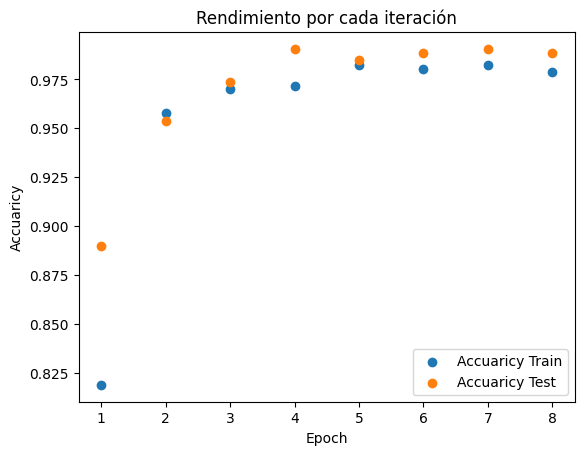

In [50]:
plot_accuracy(epochs, metrics)

## Se puede ver en este caso que a partir de 3 o 4 epoch ya se alcanza un valor de accuaricy bastante elebado, y  se observa un poco de  overfiting en 4, ademas que al usar los pesos y no actualizarlos el tiempo de entrenamiento fue de la mitad.

## El ultimo caso sera probar con pretrained = True y freeze = False, es decir que actualice los pesos.

In [68]:
model = Model(pretrained=True,freeze=False)
epochs = 8
metrics = fit(model, dataloader, epochs=8)

c:\Proyects\image_classification\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Proyects\image_classification\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 0.22171 val_acc 0.96594: 100%|██████████| 2/2 [00:20<00:00, 10.25s/it]


Epoch 1/8 loss 0.36131 val_loss 0.22171 acc 0.90346 val_acc 0.96594


val_loss 0.03629 val_acc 0.99805: 100%|██████████| 2/2 [00:20<00:00, 10.12s/it]


Epoch 2/8 loss 0.06325 val_loss 0.03629 acc 0.99554 val_acc 0.99805


val_loss 0.02690 val_acc 0.99805: 100%|██████████| 2/2 [00:19<00:00,  9.98s/it]


Epoch 3/8 loss 0.03128 val_loss 0.02690 acc 0.99726 val_acc 0.99805


val_loss 0.02079 val_acc 0.99805: 100%|██████████| 2/2 [00:19<00:00,  9.88s/it]


Epoch 4/8 loss 0.01998 val_loss 0.02079 acc 0.99944 val_acc 0.99805


val_loss 0.01706 val_acc 0.99805: 100%|██████████| 2/2 [00:23<00:00, 11.78s/it]


Epoch 5/8 loss 0.01467 val_loss 0.01706 acc 1.00000 val_acc 0.99805


val_loss 0.01433 val_acc 0.99805: 100%|██████████| 2/2 [00:21<00:00, 10.96s/it]


Epoch 6/8 loss 0.01006 val_loss 0.01433 acc 1.00000 val_acc 0.99805


val_loss 0.01338 val_acc 0.99805: 100%|██████████| 2/2 [00:20<00:00, 10.13s/it]


Epoch 7/8 loss 0.00847 val_loss 0.01338 acc 1.00000 val_acc 0.99805


val_loss 0.01230 val_acc 0.99805: 100%|██████████| 2/2 [00:19<00:00,  9.83s/it]

Epoch 8/8 loss 0.00757 val_loss 0.01230 acc 1.00000 val_acc 0.99805


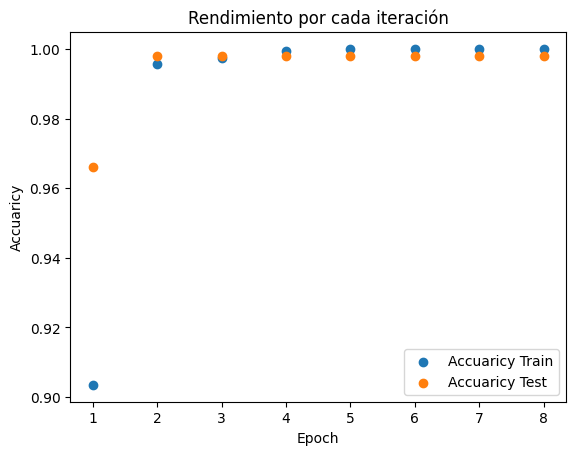

In [70]:
plot_accuracy(epochs, metrics)

## En este caso el modelo aumenta su accuaricy rapido y en el 2 epoch se alcanza un alto grado y muy bajo overfiting ademas el modelo sigue una estructura similar luego

# Finalmente este ultimo modelo sera seleccionado para realzar el modelo final.

In [72]:
def img_load(img_path):
    transform = transforms.Compose([

        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img = io.imread(img_path)
    img = Image.fromarray(img)
    img = transform(img)
    return img.unsqueeze(0) 

model.eval()
with torch.no_grad():
    predictions = model(img_load('../../data_test/scissors_1.jpg'))
    predicted_classes = torch.argmax(predictions, dim=1)
    
    
predicted_classes

tensor([1])